In [173]:
%matplotlib inline

In [174]:
from mne_bids import BIDSPath
from pipeline import Pipeline
from preprocessing import *
from erpanalysis import ERPAnalysis
import os

In [175]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root)

In [176]:
pip = Pipeline(bids_path)

In [177]:


pip.load_data()
pip.set_montage()
pip.apply_resampling(512)
pip.apply_cleaning(CleaningData(bids_path))
pip.apply_filter(SimpleMNEFilter(0.5, 50, 'firwin'))
pip.apply_ica(PrecomputedICA(bids_path))
pip.apply_rereferencing('average')
# pip.apply_ica(SimpleMNEICA('fastica', exclude=[0,1, 2]))

INFO:root:Loading Data
INFO:root:Setting montage
INFO:root:Applying resampling
INFO:root:Applying cleaning
/Users/ssaurabh/Projects/eeg-pipeline/preprocessing.py:95: UserWarning: loadtxt: Empty input file: "data/P3/sub-030/ses-P3/eeg/sub-030_ses-P3_task-P3_badChannels.tsv"
  bad_channels = np.loadtxt(ch_fname, delimiter='\t', dtype='int')
INFO:root:Applying filtering
INFO:root:Applying ICA
INFO:root:Applying re-referencing


In [178]:
erp = ERPAnalysis(-0.1, 0.8)
df = pip.compute_erp_peak(erp, 'stimulus', 0.450, 0.150, ['Cz'])

INFO:root:Trial 0: peak of 24 µV and mean of 10 µV at 598 ms in channel Cz
INFO:root:Trial 1: peak of 18 µV and mean of 7 µV at 324 ms in channel Cz
INFO:root:Trial 2: peak of 8 µV and mean of -12 µV at 342 ms in channel Cz
INFO:root:Trial 3: peak of 43 µV and mean of 14 µV at 580 ms in channel Cz
INFO:root:Trial 4: peak of 20 µV and mean of -4 µV at 561 ms in channel Cz
INFO:root:Trial 5: peak of 6 µV and mean of -16 µV at 582 ms in channel Cz
INFO:root:Trial 6: peak of 16 µV and mean of 0 µV at 502 ms in channel Cz
INFO:root:Trial 7: peak of 26 µV and mean of 14 µV at 521 ms in channel Cz
INFO:root:Trial 8: peak of 37 µV and mean of 22 µV at 381 ms in channel Cz
INFO:root:Trial 9: peak of -16 µV and mean of -32 µV at 307 ms in channel Cz
INFO:root:Trial 10: peak of 21 µV and mean of -2 µV at 564 ms in channel Cz
INFO:root:Trial 11: peak of -29 µV and mean of -59 µV at 521 ms in channel Cz
INFO:root:Trial 12: peak of -43 µV and mean of -71 µV at 566 ms in channel Cz
INFO:root:Trial 13

In [179]:
df.describe()

,peak_amp,mean_amp,latency,trial
count,91.000000,91.000000,91.000000,91.00000
mean,34.758242,5.978022,464.736264,45.00000
std,75.938183,65.560994,94.074301,26.41338
min,-270.000000,-315.000000,305.000000,0.00000
25%,10.500000,-11.000000,376.000000,22.50000
50%,28.000000,2.000000,469.000000,45.00000
75%,43.000000,17.000000,562.500000,67.50000
max,417.000000,308.000000,598.000000,90.00000


In [180]:
# df[df['channel'] == 'Cz']

In [181]:
blocks = np.array([ list(range(10*x + 1, 10*x + 6)) for x in range(1, 6)])
rare = np.array([ x + i for i, x in enumerate(range(11, 56, 10))]).tolist()
freq = np.setdiff1d(blocks.flatten(), rare).tolist()

In [182]:
pip.event_ids.keys() 

dict_keys(['response/201', 'response/202', 'stimulus/11', 'stimulus/12', 'stimulus/13', 'stimulus/14', 'stimulus/15', 'stimulus/21', 'stimulus/22', 'stimulus/23', 'stimulus/24', 'stimulus/25', 'stimulus/31', 'stimulus/32', 'stimulus/33', 'stimulus/34', 'stimulus/35', 'stimulus/41', 'stimulus/42', 'stimulus/43', 'stimulus/44', 'stimulus/45', 'stimulus/51', 'stimulus/52', 'stimulus/53', 'stimulus/54', 'stimulus/55'])

In [183]:
rare = ['stimulus/' + str(i) for i in rare]
freq = ['stimulus/' + str(i) for i in freq]

In [184]:
rare_dict = dict((k, pip.event_ids[k]) for k in rare)
freq_dict = dict((k, pip.event_ids[k]) for k in freq)

In [193]:
rare_epochs = mne.Epochs(pip.raw,pip.events, rare_dict,tmin=-0.1,tmax=0.8, reject_by_annotation=False).copy()
freq_epochs = mne.Epochs(pip.raw,pip.events, freq_dict,tmin=-0.1,tmax=0.8, reject_by_annotation=False).copy()


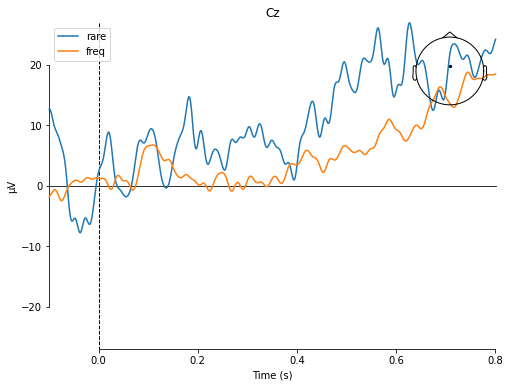

[<Figure size 576x432 with 2 Axes>]

In [200]:
mne.viz.plot_compare_evokeds({'rare': rare_epochs.average(), 'freq': freq_epochs.average()}, picks='Cz')

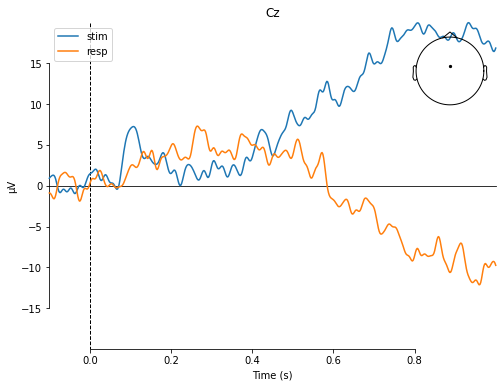

[<Figure size 576x432 with 2 Axes>]

In [201]:
_epochs = mne.Epochs(pip.raw, pip.events, pip.event_ids, tmin=-0.1,tmax=0.8, reject_by_annotation=False).copy()
mne.viz.plot_compare_evokeds({'stim': _epochs['stimulus'].average(), 'resp': _epochs['response'].average()}, picks='Cz')

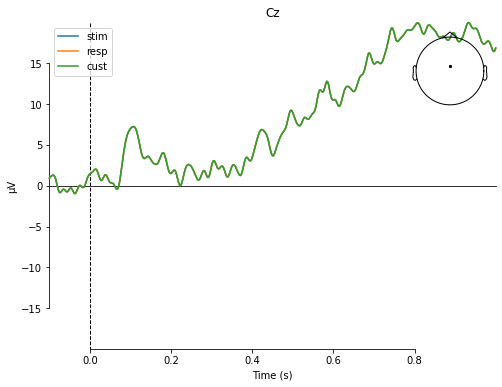

[<Figure size 576x432 with 2 Axes>]

In [202]:
wanted_keys = [e for e in pip.event_ids.keys() if "stimulus" in e]
evts_dict_stim=dict((k, pip.event_ids[k]) for k in wanted_keys if k in pip.event_ids)

# get epochs with and without rejection
epochs = mne.Epochs(pip.raw, pip.events, evts_dict_stim,tmin=-0.1,tmax=1,reject_by_annotation=False)
mne.viz.plot_compare_evokeds({'stim': epochs['stimulus'].average(), 'resp': erp.epochs['stimulus'].average(), 'cust': _epochs['stimulus'].average()}, picks='Cz')